In [7]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np

from PIL import Image
import os, glob, numpy as np
import pandas as pd
from sklearn import datasets, model_selection
from sklearn.model_selection import train_test_split


USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [8]:
img_dir = './dataset'
categories = ['bad', 'good']
np_classes = len(categories)

X = []
y = []

for idx, cat in enumerate(categories):
    
    img_dir_detail = img_dir + "/" + cat
    files = glob.glob(img_dir_detail+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    
    for i, f in enumerate(files):
        try:
            img = Image.open(f)      #폴더를 열어주고 이미지를 읽음
            img = img.convert("RGB")   #RGB로 바꿈
            resize_img = img.resize((128,128)) #이미지 크기를 모두 학습시키기 쉽게 128x128크기
            
            r, g, b = resize_img.split() # 각 쪼갠 이미지를 255로 나눠서 0~1 사이의 값이 나오도록 정규화한다.
            r_resize_img = np.asarray(np.float32(r) / 255.0)
            b_resize_img = np.asarray(np.float32(g) / 255.0)
            g_resize_img = np.asarray(np.float32(b) / 255.0)
            
            rgb_resize_img = np.asarray([r_resize_img, b_resize_img, g_resize_img]) # 이렇게 가공한 이미지를 추가한다.
            
            X.append(rgb_resize_img)
            y.append(idx) # 라벨 (ant: 0, bee: 1)
            if i % 700 == 0: #700으로 하면 폴더 명과 파일 길이를 더 
                print(cat, " : ", f)
        except:
            print(cat, str(i)+" 번째에서 에러 ")


X = np.array(X, dtype='float32')
y = np.array(y, dtype='int64')

#1 0  이면 bad
#0 1  이면 good

print("ok", len(y))

bad  파일 길이 :  434
bad  :  ./dataset/bad/4f08fc98-7d4d-43f7-921d-b2ccf8ca726d_270.jpg
good  파일 길이 :  1379
good  :  ./dataset/good/7ebb4762-7de4-4754-8cd2-2d4f743f512c_90.jpg
good  :  ./dataset/good/9eaca121-9239-49f4-9d05-34ef9f10bcaa_225.jpg
ok 1813


In [9]:
def train_val_test_split(X, y, train_size, val_size, test_size):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = test_size)
    relative_train_size = train_size / (val_size + train_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      train_size = relative_train_size, test_size = 1-relative_train_size)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X,y,0.6,0.1,0.3)

In [11]:
X_train = torch.from_numpy(X_train).float()
X_val = torch.from_numpy(X_val).float()
X_test = torch.from_numpy(X_test).float()

y_train = torch.from_numpy(y_train).long()
y_val = torch.from_numpy(y_val).long()
y_test = torch.from_numpy(y_test).long()

In [12]:
print(X_train.shape)
print(y_train.shape)

torch.Size([1087, 3, 128, 128])
torch.Size([1087])


In [13]:
#TensorDataset을 DataLoader에 전달해서 데이터의 일부만 간단히 추출
train = TensorDataset(X_train, y_train)
val = TensorDataset(X_val, y_val)
test = TensorDataset(X_test, y_test)

#순서로 섞어서 32개씩 데이터를 변환하는 DataLoader 작성
train_loader = DataLoader(train, batch_size=32, shuffle=True, num_workers = 4)
val_loader = DataLoader(val, batch_size=32, shuffle=False, num_workers = 4)
test_loader = DataLoader(test, batch_size=32, shuffle=False, num_workers = 4)

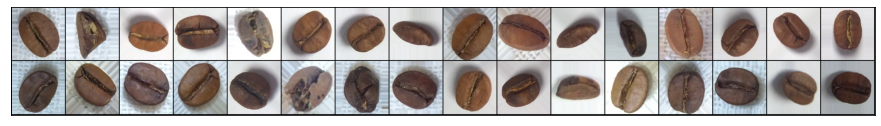

In [14]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,2))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)

In [85]:
input = torch.arange(1, 5, dtype=torch.float32).view(1, 1, 2, 2)

In [87]:
m = nn.Upsample(scale_factor=2, mode='bilinear')
n = m(input)

In [88]:
print(n.shape)

torch.Size([1, 1, 4, 4])


In [82]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        self.pool = nn.MaxPool2d(2, 2, 1)
            
        self.fc1 = nn.Linear(128 * 14 * 14, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 84)
        self.fc4 = nn.Linear(84, 2)
        
        self.upsample = nn.Upsample(scale_factor = 2, mode = "bicubic", align_corners=True)
        self.dropout1 = nn.Dropout(p=0.5, inplace=False)
            
    def forward(self, x):

        #encoder
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.dropout1(x)
        x = self.pool(x)
#        print(x.shape)

        #decoder
    
        x = x.view(x.size(0),-1)
        print('x1',x.shape)
       # x = self.upsample(x)
       # print(x.shape)
        x = F.relu(self.fc1(x))
        print('x2',x.shape)

        x = self.dropout1(x)
        print('x3',x.shape)
        x = F.relu(self.fc2(x))
        print('x4',x.shape)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = Net().to(DEVICE)

batch_size = 32

In [83]:
import torch
import torchvision
import torchsummary
model = Net().to(DEVICE)
print(model)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=2, bias=True)
  (upsample): Upsample(scale_factor=2.0, mode=bicubic)
  (dropout1): Dropout(p=0.5, inplace=False)
)


In [84]:
from torchsummary import summary
summary(model, input_size=(3,128,128))

x1 torch.Size([2, 25088])
x2 torch.Size([2, 256])
x3 torch.Size([2, 256])
x4 torch.Size([2, 128])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 124, 124]           2,432
         MaxPool2d-2           [-1, 32, 63, 63]               0
            Conv2d-3           [-1, 64, 59, 59]          51,264
         MaxPool2d-4           [-1, 64, 30, 30]               0
            Conv2d-5          [-1, 128, 26, 26]         204,928
           Dropout-6          [-1, 128, 26, 26]               0
         MaxPool2d-7          [-1, 128, 14, 14]               0
            Linear-8                  [-1, 256]       6,422,784
           Dropout-9                  [-1, 256]               0
           Linear-10                  [-1, 128]          32,896
           Linear-11                   [-1, 84]          10,836
           Linear-12                    [-1, 2]             170
Total

In [ ]:
class FocalLoss(nn.Module):
  def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
    super(FocalLoss, self).__init__()
    self.alpha = alpha
    self.gamma = gamma
    self.logits = logits
    self.reduce = reduce

  def forward(self, inputs, targets):
    BCE_loss = nn.CrossEntropyLoss()(inputs, targets)

    pt = torch.exp(-BCE_loss)
    F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

    if self.reduce:
      return torch.mean(F_loss)
    else:
      return F_loss

In [ ]:
#https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch/notebook#Focal-Loss
ALPHA = 0.8
GAMMA = 2

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = nn.functional.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view
        targets = targets.view(-1,2)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

In [ ]:
for i, data in enumerate(train_loader, 0):
    X_train, y_train = data
    X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)
    print(X_train.shape, (y_train).view(-1).shape)
    print('--------------------------------------------------------------------------')

In [ ]:
y_train.size(0)

In [ ]:
for i, data in enumerate(train_loader, 0):
    X_train, y_train = data
    X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)
    X_train = F.sigmoid(X_train) 
    X_train = X_train.view(-1)[0]
    y_train = y_train.view(-1)
    
    print(X_train.shape, y_train.shape)
    print('--------------------------------------------------------------------------')

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
for i, data in enumerate(train_loader, 0):
    X_train, y_train = data
    X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)
    
    optimizer.zero_grad()
    outputs = model(X_train)
    print(outputs.shape, y_train.shape)
    
    inputs = nn.functional.sigmoid(outputs)
    #print(inputs.shape, (y_train.view(-1)).shape)
    print((y_train.size(0)).shape)
    print('--------------------------------------------------------------------------')

torch.Size([32, 2]) torch.Size([32])


AttributeError: 'int' object has no attribute 'shape'

In [24]:
y_train.size(0)

32

In [ ]:
len(X_train)

In [ ]:
BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')

In [81]:
# https://hoya012.github.io/blog/DenseNet-Tutorial-2/
from focal_loss.focal_loss import FocalLoss
num_epoch = 100
#criterion = FocalLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

total = 0
correct = 0
running_loss_history = []
running_correct_history = []
validation_running_loss_history = []
validation_running_correct_history = []


for epoch in range(num_epoch):  
    epoch = epoch+1
    total = 0
    running_correct = 0.0
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        X_train, y_train = data
        X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(X_train)
        #print("1",outputs.shape, y_train.shape)
        loss = criterion(outputs, y_train)
        #print("2",outputs.shape, y_train.shape)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() #손실이 갖고 있는 스칼라 값을 가져올 수 있습니다.
       
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted.shape)
        total += y_train.size(0)
        running_correct += (predicted == y_train).sum().item()
       # a = torch.tensor(torch.sum(predicted == y_train).item() / len(predicted))
    
    
    # validation part
    val_total = 0
    validation_running_loss = 0.0
    validation_running_correct = 0.0
    
    for i, data in enumerate(val_loader, 0):
        X_val, y_val = data
        X_val, y_val = X_val.to(DEVICE), y_val.to(DEVICE)
        outputs = model(X_val)
        
        val_loss = criterion(outputs, y_val) 
        validation_running_loss += val_loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        val_total += y_val.size(0)
        validation_running_correct += (predicted == y_val).sum().item()
        
        
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_correct / len(train_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_correct_history.append(epoch_acc)

    val_epoch_loss = validation_running_loss / len(val_loader.dataset)
    val_epoch_acc = validation_running_correct / len(val_loader.dataset)
    validation_running_loss_history.append(val_epoch_loss)
    validation_running_correct_history.append(val_epoch_acc)
    
    print(epoch,"epoch")
    print("training loss: {:.5f}, acc: {:5f}".format(epoch_loss, epoch_acc*100))
    print("validation loss: {:.5f}, acc: {:5f}".format(val_epoch_loss, val_epoch_acc*100))
    
    print('---------------------------------------------------------------------') 

print('Finished Training')

x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Siz

x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([22, 25088])
x2 torch.Size([22, 256])
4 epoch
training loss: 0.01460, acc: 80.496780
validation loss: 0.01942, acc: 79.670330
---------------------------------------------------------------------
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.S

x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([31, 25088])
x2 torch.Size([31, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([22, 25088])
x2 torch.Size([22, 256])
8 epoch
training loss: 0.01107, acc: 86.752530
validation loss: 0.01241, acc: 85.714286
---------------------------------------------------------------------
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.S

x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Siz

x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Siz

x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([22, 25088])
x2 torch.Size([22, 256])
19 epoch
training loss: 0.01042, acc: 86.844526
validation loss: 0.01186, acc: 86.813187
---------------------------------------------------------------------
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.

x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([31, 25088])
x2 torch.Size([31, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([22, 25088])
x2 torch.Size([22, 256])
23 epoch
training loss: 0.00925, acc: 88.684453
validation loss: 0.01075, acc: 88.461538
---------------------------------------------------------------------
x1 torch.

x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Siz

x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Siz

x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([22, 25088])
x2 torch.Size([22, 256])
34 epoch
training loss: 0.00698, acc: 91.536339
validation loss: 0.01130, acc: 85.714286
---------------------------------------------------------------------
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.

x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([31, 25088])
x2 torch.Size([31, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([32, 25088])
x2 torch.Size([32, 256])
x1 torch.Size([22, 25088])
x2 torch.Size([22, 256])
38 epoch
training loss: 0.00438, acc: 94.664213
validation loss: 0.01349, acc: 84.065934
---------------------------------------------------------------------
x1 torch.

KeyboardInterrupt: 

In [ ]:
print(outputs.shape)

In [ ]:
print(y_train.shape)

In [ ]:
def plot_acc(train_losses, valid_losses):
    '''
    training과 validation loss를 시각화하는 함수
    '''
    
    # plot style을 seaborn으로 설정
    plt.style.use('seaborn')
    
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training acc') 
    ax.plot(valid_losses, color='red', label='Validation acc')
    ax.set(title="Acc over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # plot style을 기본값으로 설정
    plt.style.use('default')

In [ ]:
def plot_loss(train_losses, valid_losses):
    '''
    training과 validation loss를 시각화하는 함수
    '''
    
    # plot style을 seaborn으로 설정
    plt.style.use('seaborn')

    train_losses = list(np.array(train_losses))
    valid_losses = list(np.array(valid_losses))

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # plot style을 기본값으로 설정
    plt.style.use('default')

In [ ]:
plot_acc(running_correct_history, validation_running_correct_history)

In [ ]:
plot_loss(running_loss_history, validation_running_loss_history)

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for epoch in range(num_epoch): 

    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for data in test_loader:
            X_test, y_test = data
            X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)
            outputs = model(X_test)
            
            
            test_loss += F.cross_entropy(outputs, y_test, reduction='sum').item()
            
            _, predicted = torch.max(outputs, 1)
            c = (predicted == y_test).squeeze()
            
            for i in range(y_test.shape[0]):
                label = y_test[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            
                total += y_test.size(0)
                correct += (predicted == y_test).sum().item()
                
            
        test_loss /= len(test_loader.dataset)
        print('[%d epoch] Test Accuracy: %d %%' % (epoch + 1, 100 * correct / total),', Loss:{:.4f}'.format(test_loss))
                      

   
print('Accuracy of the network on the 1813 test images: %d %%' % (
    100 * correct / total)) 

for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        categories[i], 100 * class_correct[i] / class_total[i])) 


In [ ]:
#def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
#for epoch in range(num_epoch):  
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))